In [90]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [91]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [92]:
drive.mount('/content/drive')

# Set the file path to the Google Drive file
file_path = "/content/drive/MyDrive/Nusrat_Dataset.csv"

df_org = pd.read_csv(file_path)

# Convert all labels to lowercase and strip any leading/trailing whitespace
df_org['Labels'] = df_org['Labels'].str.lower().str.strip()

# Replace 'no' with 'no depression'
df_org['Labels'] = df_org['Labels'].replace('no', 'no depression')

df_org.dropna(inplace=True)

# Shuffle the DataFrame
df_org = df_org.sample(frac=1.0, random_state=42)


# Display the first few rows
df_org.count()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tweets    14983
Labels    14983
dtype: int64

In [93]:
labels = df_org['Labels'].unique().tolist()
labels = [s.strip() if isinstance(s, str) else s for s in labels]
print(labels)

['atypical', 'no depression', 'bipolar', 'postpartum', 'major depressive', 'psychotic']


In [94]:
for key, value in enumerate(labels):
    print(value)

atypical
no depression
bipolar
postpartum
major depressive
psychotic


In [95]:
# Original labels
labels = ['atypical', 'no depression', 'bipolar', 'postpartum', 'major depressive', 'psychotic']

# Number of labels
NUM_LABELS = len(labels)

# Create initial ID to label mapping
id2label = {id: label for id, label in enumerate(labels)}

# Create initial label to ID mapping
label2id = {label: id for id, label in enumerate(labels)}

# Sort labels and ensure 'no depression' is at index 0
sorted_labels = sorted(label2id.keys())
if 'no depression' in sorted_labels:
    sorted_labels.remove('no depression')
    sorted_labels.insert(0, 'no depression')

# Rebuild label to ID mapping
label2id = {label: idx for idx, label in enumerate(sorted_labels)}

# Rebuild ID to label mapping to reflect changes
id2label = {idx: label for idx, label in enumerate(sorted_labels)}

# Print the mappings
print("NUM_LABELS:", NUM_LABELS)
print("label2id:", label2id)
print("id2label:", id2label)

NUM_LABELS: 6
label2id: {'no depression': 0, 'atypical': 1, 'bipolar': 2, 'major depressive': 3, 'postpartum': 4, 'psychotic': 5}
id2label: {0: 'no depression', 1: 'atypical', 2: 'bipolar', 3: 'major depressive', 4: 'postpartum', 5: 'psychotic'}


In [96]:
label2id

{'no depression': 0,
 'atypical': 1,
 'bipolar': 2,
 'major depressive': 3,
 'postpartum': 4,
 'psychotic': 5}

In [97]:
id2label

{0: 'no depression',
 1: 'atypical',
 2: 'bipolar',
 3: 'major depressive',
 4: 'postpartum',
 5: 'psychotic'}

In [98]:
df_org["labels"]=df_org.Labels.map(lambda x: label2id[x.strip()])

In [99]:
df_org.head(5)

,Tweets,Labels,labels
6003,"i have a healthy head of hair, boyish good loo...",atypical,1
9482,dunlap mil sack amp lawson mil sacks he isn pl...,no depression,0
7625,still laughing abt dude saying nvm being silly...,no depression,0
4692,@mma_like I think you might have the Kanye bip...,bipolar,2
8894,because of the eras if he played vs people suc...,no depression,0


<Axes: ylabel='count'>

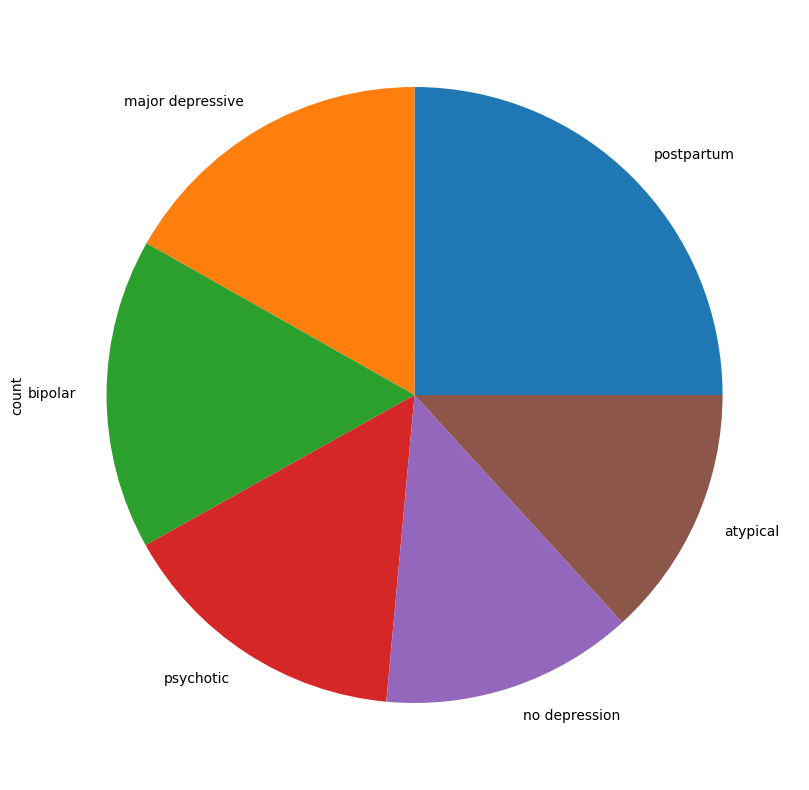

In [100]:
df_org.Labels.value_counts().plot(kind='pie', figsize=(10,10))

In [101]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [102]:
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
    "paulagarciaserrano/roberta-depression-detection",
    num_labels=NUM_LABELS,  # Make sure NUM_LABELS is set to the correct number of labels
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Add this to handle size mismatches
)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at paulagarciaserrano/roberta-depression-detection and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [103]:
SIZE= df_org.shape[0]

train_texts= list(df_org.Tweets[:SIZE//2])

val_texts=   list(df_org.Tweets[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Tweets[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [104]:
len(train_texts)

7491

In [105]:
len(train_texts), len(val_texts), len(test_texts)

(7491, 3746, 3746)

In [106]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [107]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [108]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [109]:
from transformers import TrainingArguments, Trainer

In [110]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [23]:
!pip install accelerate==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
ERROR: Operation cancelled by user


In [ ]:
!pip install transformers[torch]

In [26]:
!pip uninstall accelerate -y
!pip install accelerate
!pip uninstall transformers -y
!pip install transformers[torch]

Found existing installation: accelerate 0.32.1
Uninstalling accelerate-0.32.1:
  Successfully uninstalled accelerate-0.32.1
  Using cached accelerate-0.32.1-py3-none-any.whl (314 kB)
Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 24.2 MB/s eta 0:00:00


In [111]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [112]:
from transformers import Trainer, TrainingArguments
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [113]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.647100,1.212808,0.687400,0.682691,0.716935,0.681317
100,0.795200,0.444216,0.851842,0.858630,0.879120,0.853410
150,0.495300,0.329939,0.879872,0.887660,0.912770,0.877304


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.647100,1.212808,0.687400,0.682691,0.716935,0.681317
100,0.795200,0.444216,0.851842,0.858630,0.879120,0.853410
150,0.495300,0.329939,0.879872,0.887660,0.912770,0.877304
200,0.328700,0.336034,0.875868,0.887129,0.922357,0.873290
250,0.321000,0.260410,0.903097,0.909008,0.919734,0.904530
300,0.289600,0.252566,0.904965,0.910944,0.915479,0.909653
350,0.275600,0.329487,0.897758,0.903626,0.908013,0.903764
400,0.297400,0.293793,0.901495,0.907405,0.924054,0.903318
450,0.247500,0.252691,0.914309,0.920832,0.931184,0.914036
500,0.184600,0.285063,0.919381,0.923927,0.927562,0.921954


TrainOutput(global_step=1407, training_loss=0.2629290809848246, metrics={'train_runtime': 736.1436, 'train_samples_per_second': 30.528, 'train_steps_per_second': 1.911, 'total_flos': 1755453671823456.0, 'train_loss': 0.2629290809848246, 'epoch': 3.0})

In [114]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [115]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.070106,0.980243,0.981273,0.981117,0.981555
val,0.263759,0.928724,0.933787,0.934746,0.933493
test,0.235755,0.934063,0.937255,0.936777,0.938427


In [116]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true
              positives divided by the sum of true positives and false negatives.
            - Metrics per class (dict): Precision, recall, and F1 score for each class.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute overall metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    # Compute metrics for each class
    report = classification_report(labels, preds, output_dict=True)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Class Metrics': report  # Add class-wise metrics
    }

In [117]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(pred):
    # Extract true labels from the input object
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute overall metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Compute metrics for each class
    class_metrics = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(id2label))], output_dict=True)

    return {
        'Accuracy': accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Class Metrics': class_metrics
    }

In [118]:
# Compute metrics for the training set
train_preds = trainer.predict(train_dataloader)
train_metrics = compute_metrics(train_preds)

# Compute metrics for the validation set
val_preds = trainer.predict(val_dataloader)
val_metrics = compute_metrics(val_preds)

# Compute metrics for the test set
test_preds = trainer.predict(test_dataset)
test_metrics = compute_metrics(test_preds)

# Convert class metrics to DataFrames for easier analysis
train_class_metrics_df = pd.DataFrame(train_metrics['Class Metrics']).T
val_class_metrics_df = pd.DataFrame(val_metrics['Class Metrics']).T
test_class_metrics_df = pd.DataFrame(test_metrics['Class Metrics']).T

# Display the DataFrames with metrics for each depression type
print("Train Class Metrics:\n", train_class_metrics_df[['precision', 'recall', 'f1-score']])
print("\nValidation Class Metrics:\n", val_class_metrics_df[['precision', 'recall', 'f1-score']])
print("\nTest Class Metrics:\n", test_class_metrics_df[['precision', 'recall', 'f1-score']])

# Display overall accuracy separately
print("\n-------------------------------------------------------")
print(f"Train Accuracy: {train_metrics['Accuracy']}")
print(f"Validation Accuracy: {val_metrics['Accuracy']}")
print(f"Test Accuracy: {test_metrics['Accuracy']}")

Train Class Metrics:
                   precision    recall  f1-score
no depression      1.000000  0.993295  0.996636
atypical           0.995833  1.000000  0.997912
bipolar            0.987664  0.987664  0.987664
major depressive   0.937311  0.969531  0.953149
postpartum         0.989089  0.975780  0.982390
psychotic          0.976806  0.963061  0.969885
accuracy           0.980243  0.980243  0.980243
macro avg          0.981117  0.981555  0.981273
weighted avg       0.980527  0.980243  0.980318

Validation Class Metrics:
                   precision    recall  f1-score
no depression      0.995633  0.974359  0.984881
atypical           0.990215  0.994106  0.992157
bipolar            0.963516  0.965116  0.964315
major depressive   0.819383  0.885714  0.851259
postpartum         0.934066  0.918919  0.926431
psychotic          0.905660  0.862745  0.883682
accuracy           0.928724  0.928724  0.928724
macro avg          0.934746  0.933493  0.933787
weighted avg       0.930192  0.928724 

In [119]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [120]:
text = "some people didn't like mania and that's fine ig however (un)fortunately I have bipolar disorder and impeccable taste so I know for a fact that it fucks severely"
predict(text)

(tensor([[4.4413e-04, 1.2160e-04, 9.9886e-01, 2.3120e-04, 1.4009e-04, 2.0166e-04]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(2, device='cuda:0'),
 'bipolar')

In [121]:
model_path = "depression-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('depression-text-classification-model/tokenizer_config.json',
 'depression-text-classification-model/special_tokens_map.json',
 'depression-text-classification-model/vocab.json',
 'depression-text-classification-model/merges.txt',
 'depression-text-classification-model/added_tokens.json')

In [122]:
model_path = "depression-text-classification-model"

# Load the model correctly
model = RobertaForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer correctly, it should be a RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Initialize the pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Now you can use nlp for predictions
nlp("My mind feels like a jumbled mess. I can't focus on anything for more than a few minutes, and even then, my thoughts are all over the place. It's like my brain is working against me. #brainfog #lackoffocus")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'atypical', 'score': 0.9951009154319763}]

In [123]:
nlp("My mind feels like a jumbled mess. I can't focus on anything for more than a few minutes, and even then, my thoughts are all over the place. It's like my brain is working against me. #brainfog #lackoffocus")

[{'label': 'atypical', 'score': 0.9951009154319763}]

In [124]:
nlp("Some days it feels like I'm living in a world of chaos, and it's hard to find any stability. It's like I'm living in a constant storm.")

[{'label': 'bipolar', 'score': 0.9987257122993469}]

In [125]:
nlp("After having my baby, I find myself feeling so high one day and then so low the next. It’s a lot to navigate.")

[{'label': 'postpartum', 'score': 0.9991289973258972}]

In [126]:
nlp("The love I have for my child is immense, but the weight of exhaustion sometimes feels heavier than anything.")

[{'label': 'postpartum', 'score': 0.9991171956062317}]

In [140]:
nlp("I sometimes experience intense mood swings, alternating between periods of extreme happiness and energy to deep depression")

[{'label': 'bipolar', 'score': 0.9797244071960449}]